In [10]:
import os
from torch.utils.data import Dataset, DataLoader
import re
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.transforms.functional as TF
import random
from depth_net import DepthV3
from lib.loss_depth import L2Loss, GradientLoss, NormalLoss, BerHu
from torch import optim
import time
import torch

In [2]:
class FaceDepthDataset(Dataset):
    def __init__(self, depth_root, rgb_root, data_type='train'):
        start = 1
        end = 69   
        if data_type == "val":
            start = 70
            end = 84
        if data_type == "test":
            start = 85
            end = 100
            
        self.depth_file_paths = []
        self.rgb_file_paths = []
        for person in os.listdir(depth_root):
            if int(person) >= start and int(person) <= end:
                depth_folder = os.path.join(depth_root, person)
                for img in os.listdir(depth_folder):
                    frame_number_regex = re.search('frame_(.*)_face', img)
                    if frame_number_regex:
                        frame_number = frame_number_regex.group(1)
                        self.depth_file_paths.append(os.path.join(depth_root, 
                                                             person, 
                                                             "frame_%s_face_depth.png" % frame_number))
                        self.rgb_file_paths.append(os.path.join(rgb_root, 
                                                           person, 
                                                             "frame_%s_face_rgb.png" % frame_number))
                    
    def __len__(self):
        return len(self.depth_file_paths)
    
    def __getitem__(self, idx):
        depth_img = Image.open(self.depth_file_paths[idx])
        rgb_img = Image.open(self.rgb_file_paths[idx])

        rgb_img = transforms.Compose([
            transforms.ColorJitter([0.6, 1.4], [0.6, 1.4], [0.6, 1.4])
        ])(rgb_img)
        
        # Random horizontal flip
        if random.random() > 0.5:
            depth_img = TF.hflip(depth_img)
            rgb_img = TF.hflip(rgb_img)
        
        choice = random.randint(0, 3)
        depth_img = TF.rotate(depth_img, choice * 90)
        rgb_img = TF.rotate(rgb_img, choice * 90)

            
            
        depth_img = TF.to_tensor(depth_img)
        rgb_img = TF.to_tensor(rgb_img)
        
        
        rgb_img = TF.normalize(rgb_img, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        
        return (rgb_img, depth_img)

In [3]:
depth_root = 'depth_data/depth'
rgb_root = 'depth_data/rgb'
train_dataset = FaceDepthDataset(depth_root, rgb_root, 'train')

In [4]:
batch_size = 8
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

torch.Size([8, 1, 100, 100])


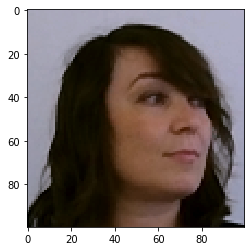

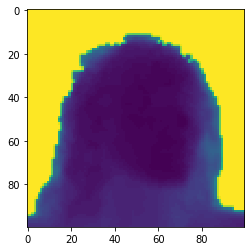

In [5]:
for i, batch in enumerate(dataloader):
    print(batch[1].shape)
    rgb_img = batch[0][0]
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.255]
    )
    rgb_img = inv_normalize(rgb_img)
    plt.imshow(rgb_img.permute(1, 2, 0))
    plt.show()
    plt.imshow(batch[1][0].squeeze())
    plt.show()
    break

In [6]:
estimator = DepthV3((100, 100))
estimator.cuda();

In [7]:
lr = 0.0001
optimizer = optim.Adam(estimator.parameters(), lr=lr)
# optimizer = optim.SGD(estimator.parameters(), lr, momentum=0.9, weight_decay=1e-4)

lossGrad = GradientLoss()
lossNormal = NormalLoss()
berhu = BerHu()

In [8]:
start_epoch = 1
end_epoch = 20

In [9]:
st_time = time.time()
for epoch in range(start_epoch, end_epoch):
    mess = 'Train time {0}'.format(time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - st_time)) + ', ' + 'Training started')
    print(mess)
    
    train_count = 0
    loss_avg = 0.0
    loss_berhu_avg= 0.0
    loss_normal_avg = 0.0
    loss_grad_avg = 0.0
    train_loss_avg = 0.0
    estimator.train()
    optimizer.zero_grad()
    
    for i, data in enumerate(dataloader):
        rgbs, depths = data
        rgbs, depths = rgbs.float().cuda(), depths.float().cuda()
        
        pred_depths = estimator(rgbs)
        
        loss_Berhu = berhu(pred_depths, depths) 
        loss_grad = lossGrad(pred_depths, depths) 
        loss_normal = lossNormal(pred_depths, depths) 
        total_loss = loss_Berhu + loss_normal + loss_grad
        
        total_loss.backward()
        

        loss_avg = total_loss.item()
        loss_berhu_avg = loss_Berhu.item()
        loss_normal_avg = loss_normal.item()
        loss_grad_avg = loss_grad.item()
        train_loss_avg = total_loss.item()
        train_count += batch_size
        
        optimizer.step()
        optimizer.zero_grad()
        
        if train_count % (batch_size * 10) == 0:
            mess = 'Train time {0} Epoch {1} Batch {2} Frame {3}\nAvg_loss: {4:.6f} loss_l2: {5:.6f} loss_grad: {6:.6f} loss_normal: {7:.6f}'.format(
                                time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - st_time)), 
                                epoch, int(train_count / batch_size), 
                                train_count, 
                                loss_avg / batch_size, 
                                loss_berhu_avg / batch_size, 
                                loss_grad_avg / batch_size, 
                                loss_normal_avg / batch_size)
            print(mess)
        
        if train_count != 0 and train_count % 1000 == 0:                    
            torch.save(estimator.state_dict(), 'models/depth_model_current.pth')
        
    print('>>>>>>>>----------epoch {0} train finish---------<<<<<<<<'.format(epoch))

        

Train time 00h 00m 00s, Training started


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Train time 00h 00m 03s Epoch 1 Batch 10 Frame 80
Avg_loss: -0.106051 loss_l2: 0.015911 loss_grad: -0.125266 loss_normal: 0.003303
Train time 00h 00m 06s Epoch 1 Batch 20 Frame 160
Avg_loss: -0.117872 loss_l2: 0.017604 loss_grad: -0.137633 loss_normal: 0.002157
Train time 00h 00m 09s Epoch 1 Batch 30 Frame 240
Avg_loss: -0.126516 loss_l2: 0.014087 loss_grad: -0.142710 loss_normal: 0.002106
Train time 00h 00m 12s Epoch 1 Batch 40 Frame 320
Avg_loss: -0.131455 loss_l2: 0.009877 loss_grad: -0.143142 loss_normal: 0.001811
Train time 00h 00m 15s Epoch 1 Batch 50 Frame 400
Avg_loss: -0.130800 loss_l2: 0.010027 loss_grad: -0.142786 loss_normal: 0.001958
Train time 00h 00m 17s Epoch 1 Batch 60 Frame 480
Avg_loss: -0.134361 loss_l2: 0.008721 loss_grad: -0.144919 loss_normal: 0.001837
Train time 00h 00m 20s Epoch 1 Batch 70 Frame 560
Avg_loss: -0.125612 loss_l2: 0.014506 loss_grad: -0.142524 loss_normal: 0.002406
Train time 00h 00m 23s Epoch 1 Batch 80 Frame 640
Avg_loss: -0.137648 loss_l2: 0.008

NameError: name 'torch' is not defined